# Jared Godar: Zillow Home Value Predictions

---

## Goal

- I will biuld and evaluate models to predict home value in order to identify over and under-valued properties.

- I will show the dirstibution of tax rates by county so we can evaluate how a given property compares others.

## Description

- The ability to accurately price a home in relation to others is essential. This allows sellers to ensure they are maximizing their profits and investors to find undervalued properties. 

- Analysis of past transactions will allow the creation of a model to accurately predict home values.

Here, I import libraries that will be used in data cleaning, analysis, visualization, modeling, and evaluation.

In [46]:
# Basic libraries
import pandas as pd
import numpy as np 

#Vizualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.formula.api import ols

from datetime import date
from scipy import stats


## Evaluation tools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

#Custim functions
from env import host, user, password #Database credentials
import zillo_wrangle
import eval_model

---

## Data Wrangling

- Initial query pulls relevant data from the SQL database for 52275 homes sold in 2017.
- 56 null values in initial pull.
- Removed outliers with a cutoff of 1.5x interquartile range. (7322 records removed)
- Removed 31 remaining records with null values.
- Changed data types as appropriate.
- Added county and state from fips data.
- Added county mean home prices.
- Added column for age of home in years.
- One-hot encoded counties.
- Added tax rate columns.
- Split date into train, validate, and test sets.
- Added baseline as median home price (less sensitive to ouliers than mean).
- Split each set in to X / y feature / target sets.
- Used robust scaler to scale numeric data - fit on train and apllied to all sets.

In [2]:
# Import, clean, and split data using custom function

train, X_train, y_train, X_validate, y_validate, X_test, y_test = zillo_wrangle.wrangle()

### Data Dictionary

|Target|Datatype|Definition|
|:-------|:--------|:----------|
| home_value | float64 | home value in dollars|


____
| variable  |     Dtype    | Definition |
|:----------|:-----------------------|:-----------|
|bedrooms    | float64 | Number of bedrooms |
|bathrooms   | float64 | Number of bathrooms |
|square_feet |  int64 | Area in square feet |
|year |  int64 | Year built |
|taxes       | float64 | Tax amount dollars |
|fips_number   |   int64 | Area code |
|zip_code      |   category | Zip Code |
|county_Orange      |   unit8 | Encoded county information |
|county_Ventura      |   unit8 | Encoded county information |
|county_avg (engineered) |  float64 | Average home price in county |
|baseline  (engineered) |  float64 | baseline |

---

## Exploratory Data Analysis

**INITIAL QUESTIONS**

1. What are factors that drive home prices?
2. What are factors that decrease home prices?
3. What features matter least?
4. Is there a significant difference in home value by county?

### Question 1: What drives home prices?

Home size has the largest impact, followed by number of bathrooms then number of bedrooms.


In [119]:
import eval_model

The p-value is: 0.000000. There is 0.0% chance that we see these results by chance.
r = 0.43


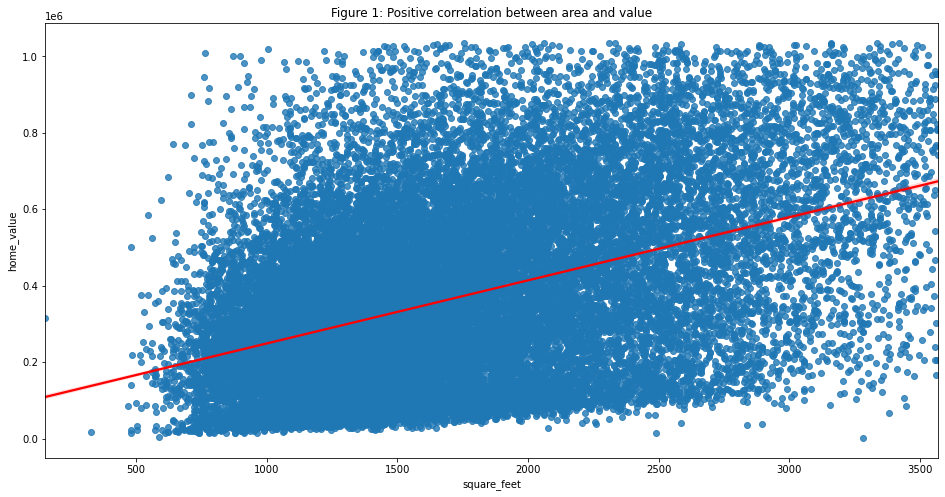

In [123]:
plt.figure(figsize=(16,8))
eval_model.correlation_exploration(train, 'square_feet', 'home_value')
plt.title('Figure 1: Positive correlation between area and value');


There is a statistically significant correlation between home area and home price

The p-value is: 0.000000. There is 0.0% chance that we see these results by chance.
r = 0.36


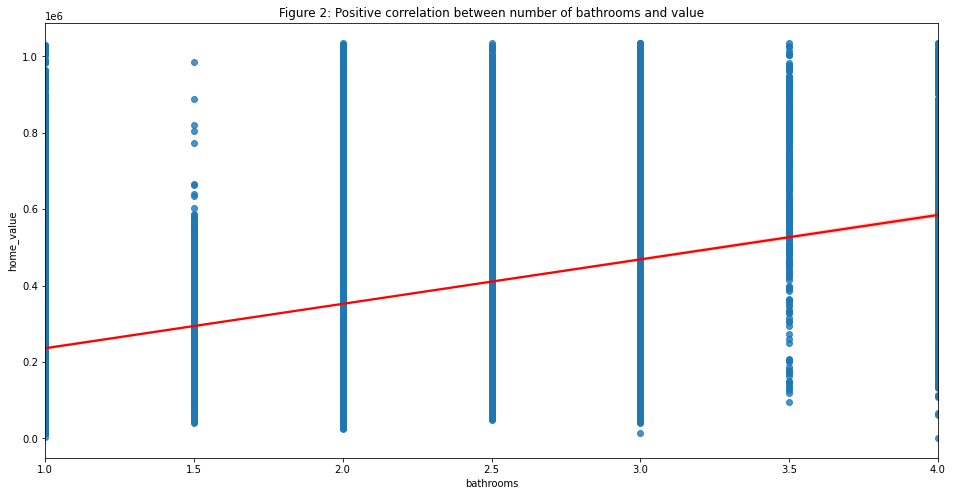

In [125]:
plt.figure(figsize=(16,8))

eval_model.correlation_exploration(train, 'bathrooms', 'home_value')

plt.title('Figure 2: Positive correlation between number of bathrooms and value');

There is a statistically significant correlation between home area and home price

The p-value is: 0.000000. There is 0.0% chance that we see these results by chance.
r = 0.19


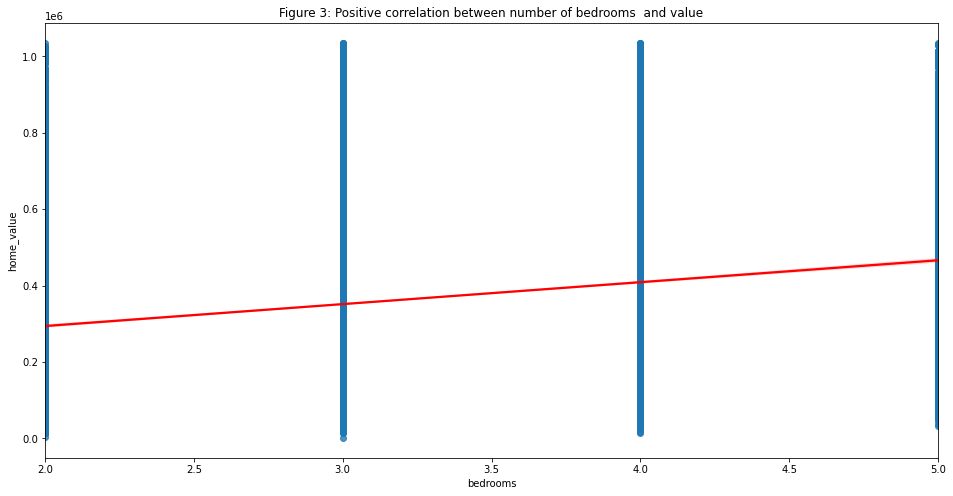

In [126]:
plt.figure(figsize=(16,8))

eval_model.correlation_exploration(train, 'bedrooms', 'home_value')

plt.title('Figure 3: Positive correlation between number of bedrooms  and value');

There is a statistically significant correlation between home area and home price

### Question 2: What factors decrease home price?

The p-value is: 0.000000. There is 0.0% chance that we see these results by chance.
r = -0.23


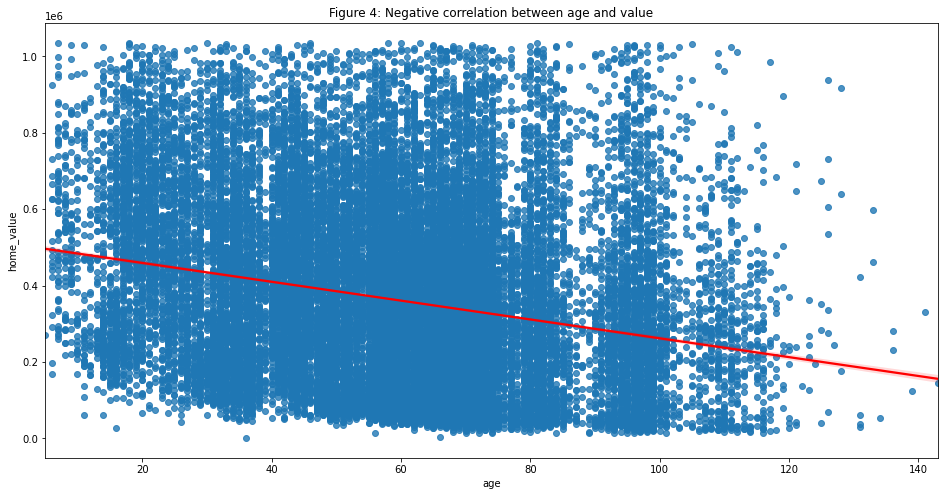

In [127]:
plt.figure(figsize=(16,8))

eval_model.correlation_exploration(train, 'age', 'home_value')

plt.title('Figure 4: Negative correlation between age and value');

There is a statistically significant correlation between home area and home price

### Question 3: Are there any factors that don't matter?

- In this initial, sparse dataset used for the MVP model, there is a statistically significant correlation between each driver and the home price.

- Number of bedrooms is least strongly correlated with home price.

### Question 4: Is there a difference in average price by county?

In [37]:
# Make a separate dataframe for each county

la = train[train.county=='Los Angeles'].home_value
oc = train[train.county=='Orange'].home_value
ven = train[train.county=='Ventura'].home_value

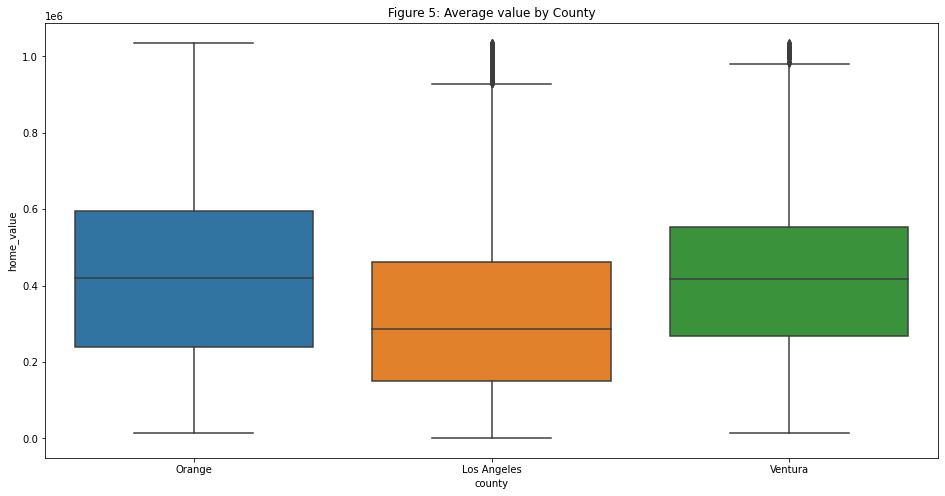

In [128]:
# Vizualize prices by county
plt.figure(figsize=(16,8))

ax = sns.boxplot(x=train.county, y=train.home_value)
#ax = sns.swarmplot(x=train.county, y=train.home_value, color ='.25')
plt.title('Figure 5: Average value by County');

- Perform Kruskal-Wallis H-test to see if there is a difference by county.

- Using a nonparametric test since the underlying distributions are not normal.

In [38]:
stats.kruskal(la, oc, ven)

KruskalResult(statistic=1357.533431618437, pvalue=1.6419533891990053e-295)

- There are differences by county. 

- Post-hoc, pairwaise analysis can determine which samples are different in which direction.

In [40]:
# Is LA lower than OC
stats.mannwhitneyu(la, oc, alternative ='less')

MannwhitneyuResult(statistic=67523869.0, pvalue=3.841782942079302e-242)

- Los Angeles County prices are lower, on average, than Orange County 

In [41]:
# Is LA lower than Ventura

stats.mannwhitneyu(la, ven, alternative ='less')

MannwhitneyuResult(statistic=21523832.5, pvalue=5.9695151055108555e-105)

- Los Angeles County prices are lower, on average, than Ventura County 

In [42]:
# Is Ventura Lower than Orange

stats.mannwhitneyu(ven, oc, alternative ='less')

MannwhitneyuResult(statistic=11424918.0, pvalue=0.11480778422845389)

Ventura is not statistically lower than orange

In [43]:
# Is there a difference between Ventura and orange

stats.mannwhitneyu(ven, oc)

MannwhitneyuResult(statistic=11424918.0, pvalue=0.11480778422845389)

In [44]:
stats.kruskal(oc, ven)

KruskalResult(statistic=1.443249323379644, pvalue=0.2296142522360047)

There is no statistically significant difference between the mean home values in Orange and Ventura Counties.

---

## Modeling

First, I will build a minimal model using only bedrooms, bathrooms, and area.

In [58]:
# Create Model
ols_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet', data=train).fit()

# Make predictions
ols_yhat = ols_model.predict(X_train)
X_train['mvp_prdictions']=ols_yhat

#  DataFrame for evaluating model 
ols_eval = y_train.copy()
validate_eval = y_validate.copy()
ols_eval = pd.DataFrame(ols_eval)
validate_eval = pd.DataFrame(validate_eval)
ols_eval.rename(columns={'home_value': 'actual'}, inplace=True)
validate_eval.rename(columns={'home_value': 'actual'}, inplace=True)

# Add baseline - median home value
ols_eval['baseline_yhat'] = ols_eval['actual'].median()
validate_eval['baseline_yhat'] = ols_eval['actual'].median()

# Add model prediction
ols_eval['ols_yhat'] = ols_model.predict(X_train)
validate_eval['ols_yhat'] = ols_model.predict(X_validate)

# Calculate and Add Residuals Column for Plotting
ols_eval['residuals'] = ols_eval.ols_yhat - ols_eval.actual
validate_eval['residuals'] = validate_eval.ols_yhat - validate_eval.actual

#  Compute the RMSE  and R2 for  ols model and baseline 
baseline_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat)))
ols_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat)))
pct_change=round(((ols_RMSE-baseline_RMSE)/baseline_RMSE)*100, 2)
rmse_validate = round(sqrt(mean_squared_error(validate_eval.actual, validate_eval.ols_yhat)))
baseline_r2 = round(r2_score(ols_eval.actual, ols_eval.baseline_yhat), 2)
ols_train_r2 = round(r2_score(ols_eval.actual, ols_eval.ols_yhat), 2)
ols_validate_r2 = round(r2_score(validate_eval.actual, validate_eval.ols_yhat), 2)

#Output Findings

print(f'My model has value: {ols_RMSE < baseline_RMSE}')
print()
print(f'Baseline RMSE: {baseline_RMSE}')
print(f'My model train RMSE: {ols_RMSE}')
print(f'My model validate RMSE: {rmse_validate}')
print(f'RMSE difference baseline to model: {baseline_RMSE- ols_RMSE}')
print(f'RMSE difference train to validate: {ols_RMSE- rmse_validate}')
print(f'RMSE improvement: {pct_change}%')
print()
print(f'Baseline R2: {baseline_r2}')
print(f'Model train  R2: {ols_train_r2}')
print(f'Model Validate R2: {ols_validate_r2}')



My model has value: True

Baseline RMSE: 235257
My model train RMSE: 209005
My model validate RMSE: 210823
RMSE difference baseline to model: 26252
RMSE difference train to validate: -1818
RMSE improvement: -11.16%

Baseline R2: -0.02
Model train  R2: 0.2
Model Validate R2: 0.19


- Model improves from baseline prediction
- RMSE and R2 similar for train and validate

---

### Make second OLS model including age

In [59]:
ols2_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet + age',  data=train).fit() #Create model
ols2_yhat = ols2_model.predict(X_train) # Make predictions
X_train['model2']=ols2_yhat
# Add to eval
ols_eval['ols2_yhat'] = ols2_model.predict(X_train)
validate_eval['ols2_yhat'] = ols2_model.predict(X_validate)
ols_eval['ols2_residuals'] = ols_eval.ols2_yhat - ols_eval.actual
validate_eval['ols2_residuals'] = validate_eval.ols2_yhat - validate_eval.actual
#Calculate Evaluation metrics
baseline_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat)))
ols_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat)))
ols2_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols2_yhat)))
pct_change_baseline=round(((ols_RMSE-baseline_RMSE)/baseline_RMSE)*100, 2)
pct_change_last_model=round(((ols2_RMSE-ols_RMSE)/ols_RMSE)*100, 2)
rmse_validate = round(sqrt(mean_squared_error(validate_eval.actual, validate_eval.ols2_yhat)))
baseline_r2 = round(r2_score(ols_eval.actual, ols_eval.baseline_yhat), 2)
ols2_train_r2 = round(r2_score(ols_eval.actual, ols_eval.ols2_yhat), 2)
ols2_validate_r2 = round(r2_score(validate_eval.actual, validate_eval.ols2_yhat), 2)
# Display findings
print(f'My model has value: {ols_RMSE < baseline_RMSE}')
print(f'My model beats previous model: {ols2_RMSE < ols_RMSE}')
print()
print(f'Baseline RMSE: {baseline_RMSE}')
print(f'Model 1 RMSE: {ols_RMSE}')
print(f'Currennt model train RMSE: {ols2_RMSE}')
print(f'Currennt model validate RMSE: {rmse_validate}')
print()
print(f'Current model RMSE difference from baseline: {baseline_RMSE- ols_RMSE}')
print(f'RMSE difference train to validate: {ols2_RMSE- rmse_validate}')
print(f'Current model baseline RMSE improvement: {pct_change_baseline}%')
print(f'Current model RMSE improvement from last model: {pct_change_last_model}%')
print()
print(f'Baseline R2: {baseline_r2}')
print(f'Model train  R2: {ols2_train_r2}')
print(f'Model Validate R2: {ols2_validate_r2}')




My model has value: True
My model beats previous model: True

Baseline RMSE: 235257
Model 1 RMSE: 209005
Currennt model train RMSE: 208989
Currennt model validate RMSE: 210802

Current model RMSE difference from baseline: 26252
RMSE difference train to validate: -1813
Current model baseline RMSE improvement: -11.16%
Current model RMSE improvement from last model: -0.01%

Baseline R2: -0.02
Model train  R2: 0.2
Model Validate R2: 0.19


- Model adding age improves from previous model
- RMSE and R2 similar for training and validate

---

### Make third OLS model incorporating counties

In [60]:
# Make model and predictions
ols3_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet + age + county_Orange + county_Ventura',  data=train).fit() #Create model
ols3_yhat = ols3_model.predict(X_train) # Make predictions
X_train['model3']=ols3_yhat
ols_eval['ols3_yhat'] = ols3_model.predict(X_train)
ols_eval['ols3_residuals'] = ols_eval.ols3_yhat - ols_eval.actual
validate_eval['ols3_yhat'] = ols3_model.predict(X_validate)
validate_eval['ols3_residuals'] = validate_eval.ols3_yhat - validate_eval.actual
# Calculate evaluation metrics
baseline_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat)))
ols_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat)))
ols2_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols2_yhat)))
ols3_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols3_yhat)))

pct_change_baseline=round(((ols3_RMSE-baseline_RMSE)/baseline_RMSE)*100, 2)
pct_change_last_model=round(((ols3_RMSE-ols2_RMSE)/ols2_RMSE)*100, 2)

ols3_train_r2 = round(r2_score(ols_eval.actual, ols_eval.ols3_yhat), 2)
ols3_validate_r2 = round(r2_score(validate_eval.actual, validate_eval.ols3_yhat), 2)
# Display findings
print(f'My model has value: {ols3_RMSE < baseline_RMSE}')
print(f'My model beats previous model: {ols3_RMSE < ols2_RMSE}')
print()
print(f'Baseline RMSE: {baseline_RMSE}')
print(f'Model 1 RMSE: {ols_RMSE}')
print(f'Model 2 RMSE: {ols2_RMSE}')
print(f'Current model RMSE: {ols3_RMSE}')
print()
print(f'Current model RMSE difference from baseline: {baseline_RMSE- ols3_RMSE}')
print(f'Current model baseline RMSE improvement: {pct_change_baseline}%')
print(f'Current model RMSE improvement from last model: {pct_change_last_model}%')
print()
print(f'Baseline R2: {baseline_r2}')
print(f'Current Model train  R2: {ols3_train_r2}')
print(f'Current Model Validate R2: {ols3_validate_r2}')


My model has value: True
My model beats previous model: True

Baseline RMSE: 235257
Model 1 RMSE: 209005
Model 2 RMSE: 208989
Current model RMSE: 207035

Current model RMSE difference from baseline: 28222
Current model baseline RMSE improvement: -12.0%
Current model RMSE improvement from last model: -0.93%

Baseline R2: -0.02
Current Model train  R2: 0.21
Current Model Validate R2: 0.21


---

### Test

In [92]:
# Make model and predictions
ols3_yhat_test = ols3_model.predict(X_test) # Make predictions
X_train['model3_test']=ols3_yhat_test
ols_eval['ols3_yhat_test'] = ols3_yhat_test
ols_eval['ols3_residuals_test'] = ols_eval.ols3_yhat_test - ols_eval.actual

# Calculate evaluation metrics
baseline_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat)))


ols_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat)))


ols2_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols2_yhat)))


ols3_RMSE = round(sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols3_yhat)))

ols3_RMSE_test = round(sqrt(mean_squared_error(y_test, ols3_yhat_test)))



pct_change_baseline=round(((ols3_RMSE_test-baseline_RMSE)/baseline_RMSE)*100, 2)
ols3_train_r2 = round(r2_score(ols_eval.actual, ols_eval.ols3_yhat), 2)
ols3_validate_r2 = round(r2_score(validate_eval.actual, validate_eval.ols3_yhat), 2)
ols3_test_r2 = round(r2_score(y_test, ols3_yhat_test), 2)

# Display findings
print(f'My model has value: {ols3_RMSE < baseline_RMSE}')
print(f'My model beats previous model: {ols3_RMSE < ols2_RMSE}')
print()
print(f'Baseline RMSE: {baseline_RMSE}')
print(f'Model 1 RMSE: {ols_RMSE}')
print(f'Model 2 RMSE: {ols2_RMSE}')
print(f'Current model RMSE: {ols3_RMSE}')
print()
print(f'Current model RMSE test: {ols3_RMSE_test}')
print()
print(f'Current model RMSE difference from baseline: {baseline_RMSE- ols3_RMSE}')
print(f'Current model baseline RMSE improvement: {pct_change_baseline}%')
print(f'Current model RMSE improvement from last model: {pct_change_last_model}%')
print()
print(f'Baseline R2: {baseline_r2}')
print(f'Current Model train  R2: {ols3_train_r2}')
print(f'Current Model Validate R2: {ols3_validate_r2}')
print(f'Current Model Test R2: {ols3_test_r2}')



My model has value: True
My model beats previous model: True

Baseline RMSE: 235257
Model 1 RMSE: 209005
Model 2 RMSE: 208989
Current model RMSE: 207035

Current model RMSE test: 204951

Current model RMSE difference from baseline: 28222
Current model baseline RMSE improvement: -12.88%
Current model RMSE improvement from last model: -0.93%

Baseline R2: -0.02
Current Model train  R2: 0.21
Current Model Validate R2: 0.21
Current Model Test R2: 0.22


---

### Vizualize error

In [96]:
ols_eval.head()

,actual,baseline_yhat,ols_yhat,residuals,ols2_yhat,ols2_residuals,ols3_yhat,ols3_residuals,ols3_yhat_test,ols3_residuals_test
41341,707082.0,330453.0,560247.371807,-146834.628193,558632.745338,-148449.254662,596874.436962,-110207.563038,NaN,NaN
36463,666000.0,330453.0,339309.981264,-326690.018736,340495.998005,-325504.001995,381336.194211,-284663.805789,NaN,NaN
42414,609150.0,330453.0,361399.231484,-247750.768516,364667.963533,-244482.036467,396866.815786,-212283.184214,NaN,NaN
44293,819623.0,330453.0,480010.999460,-339612.000540,481342.288959,-338280.711041,512041.855227,-307581.144773,NaN,NaN
35826,83402.0,330453.0,343507.457483,260105.457483,345406.938138,262004.938138,383815.833353,300413.833353,NaN,NaN


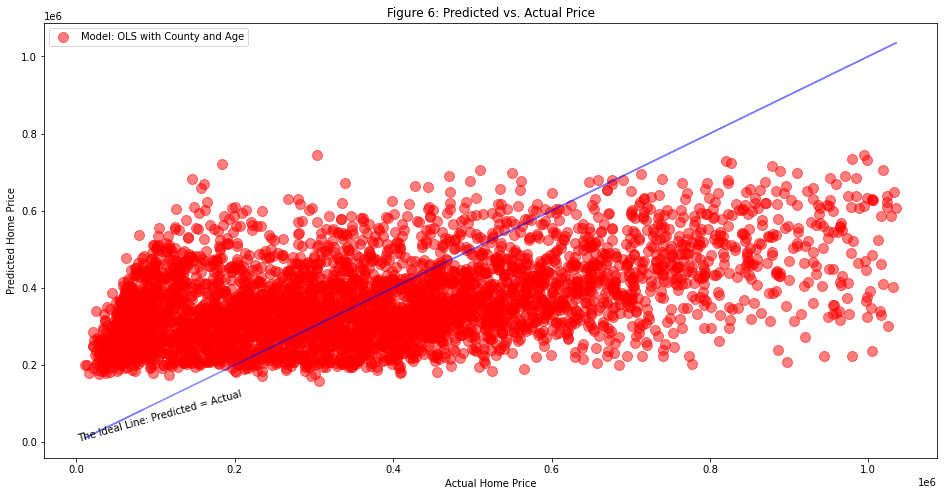

In [115]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.plot(y_test, y_test, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_test, ols3_yhat_test, 
            alpha=.5, color="red", s=100, label="Model: OLS with County and Age")


plt.legend()
plt.xlabel("Actual Home Price")
plt.ylabel("Predicted Home Price")
plt.title("Figure 6: Predicted vs. Actual Price")
plt.show()

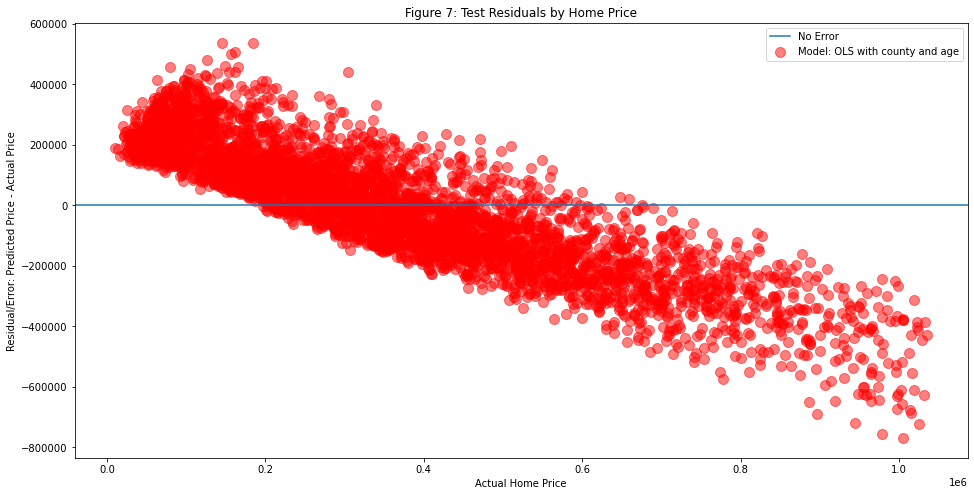

In [116]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_test, ols3_yhat_test-y_test, 
            alpha=.5, color="red", s=100, label="Model: OLS with county and age")

plt.legend()
plt.xlabel("Actual Home Price")
plt.ylabel("Residual/Error: Predicted Price - Actual Price")
plt.title("Figure 7: Test Residuals by Home Price")

plt.show()

- I have generated three ols models.
- Each is an improvement from baseline and from the previous model

### Feature engineering / Model improvement

- I have modeled using all of the originally considered data (area, bedrooms, bathrooms, age, and county).
- Go back to the original dataset to find additional features to model on.
- Consider feature engineering to combine or create addtional meaningful features.

---

### Conclusion

- I have build a model that adds predictive value.
- The most important features, in order, are area, bathrooms, then bedrooms and there is a negative corrolation with age.
- Los Angeles County homes have lower values on average than either Ventura or Orange counties.
- There is no difference in average price between Ventura and Orange.


### Recommendations

- Can use this model to predict home prices.
- Continue to build and refine model with different features

### Next Steps
- Continue feature engineering
    - Cluster homes based on lat / long to create more granular location data
    - Build features for pool, garage, fireplace, air conditioner, etc
- Use k-best and recursive elimination to select most important features
- Try polynomial and tweedie models